<a href="https://colab.research.google.com/github/trishaa4144/cmsc320-final/blob/rat_clean/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Initial Data Cleaning

We will start by cleaning our dataset to remove null values, and narrows our dataset down to certain columns.

First, we import our dataset.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("Rat_Sightings_20240917.csv", low_memory=False)

We filter out unnecessary/sparse columns like "Taxi Pick Up Location", "Bridge Highway Name", etc. This way, we cut the number of columns from 38 to 7 columns.

We are deciding to look at the following important columns: Created Date, Location Type, Incident Zip, Community Board, Borough, Latitude, Longitude.


In [3]:
# Keep only the necessary columns
df = df[['Created Date', 'Location Type', 'Incident Zip', 'Community Board', 'Borough', 'Latitude', 'Longitude']]

Next, we remove Boroughs that are "Unspecified" from the dataframe.

In [4]:
# Drop rows with unspecified boroughs
df = df[df['Borough'] != 'Unspecified']
df.reset_index(drop=True, inplace=True)

Next, drop NA values and duplicates from the dataset.

In [5]:
df.dropna(subset=['Created Date', 'Location Type', 'Incident Zip', 'Community Board', 'Borough', 'Latitude', 'Longitude'], inplace=True)
df.drop_duplicates(inplace=True)

Now that we have done the initial cleaning of our dataset, lets proceed forward and visualize how rat sightings compare across location, time, and income level.

First, let's visualize how rat sightings compare across Zip Codes

# Part 2: General EDA & Characteristics of Data




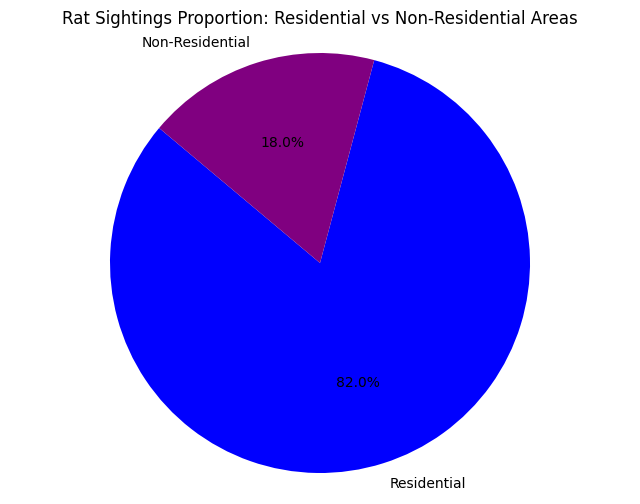

In [6]:
# Get unique values in 'Location Type'
unique_location_types = df['Location Type'].unique()

# Define mapping for residential categories
residential_mapping = {
    'Single Room Occupancy (SRO)': 'Single',
    '1-2 Family Dwelling': '1-2 Family Apartment',
    '1-2 FamilyDwelling': '1-2 Family Apartment',
    '3+ Family Apt. Building': '3+ Family',
    '3+ Family Apartment Building': '3+ Family',
    '3+ Family Apt.': '3+ Family',
    '3+Family Apt.': '3+ Family',
    '3+ Family Apt': '3+ Family',
    '1-3 Family Dwelling': '1-3 Family Dwelling',
    '1-3 Family Mixed Use Building': '1-3 Family Mixed',
    '1-2 Family Mixed Use Building': '1-2 Family Mixed',
    '3+ Family Mixed Use Building': '3+ Family Mixed',
    'Private House': 'Private House',
    'Apartment': 'Apartment',
    'Residential Property': 'Residential Property'
}

# Apply mapping to the 'Location Type' column for residential data
df['Location Type'] = df['Location Type'].replace(residential_mapping)

# Create the residential and non-residential DataFrames
residential_df = df[df['Location Type'].isin(residential_mapping.values())]
nonresidential_df = df[~df['Location Type'].isin(residential_mapping.values())]
nonresidential_df = nonresidential_df[~nonresidential_df['Location Type'].isin(['Other', 'Other (Explain Below)'])]

# Basic Data Exploration - residential vs nonresidential pie chart
residential_count = residential_df.shape[0]
nonresidential_count = nonresidential_df.shape[0]

# Data for the pie chart
labels = ['Residential', 'Non-Residential']
sizes = [residential_count, nonresidential_count]
colors = ['blue', 'purple']

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Rat Sightings Proportion: Residential vs Non-Residential Areas')
# Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.axis('equal')
plt.show()

In [7]:
# Rough overview of features we want to consider (main characteristics of dataset)

# All boroughs and number of sightings in each
boroughs = df.groupby(['Borough']).groups.keys()
print("********** Boroughs **********")
print(list(boroughs))
mode = df.groupby(['Borough']).count()['Created Date']
print(mode)

********** Boroughs **********
['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']
Borough
BRONX            44464
BROOKLYN         91100
MANHATTAN        64352
QUEENS           38123
STATEN ISLAND     9684
Name: Created Date, dtype: int64


There are 5 boroughs from which rat sightings were reported (as there are 5 boroughs in New York City). We see from the counts of sightings per each borough that Brooklyn has the highest count, 91100, and Staten Island has the fewest, 9684.

In [8]:
# All location types and number of sightings in each
location_type = df.groupby(['Location Type']).groups.keys()
print("\n********** Location Type **********")
print(list(location_type))
mode = df.groupby(['Location Type']).count()['Created Date']
print(mode)


********** Location Type **********
['1-2 Family Apartment', '1-2 Family Mixed', '1-3 Family Dwelling', '1-3 Family Mixed', '3+ Family', '3+ Family Mixed', 'Abandoned Building', 'Apartment', 'Beach', 'Building (Non-Residential)', 'Cafeteria - Public School', 'Catch Basin/Sewer', 'Catering Service', 'Commercial Building', 'Commercial Property', 'Construction Site', 'Day Care/Nursery', 'Government Building', 'Grocery Store', 'Ground', 'Hospital', 'Office Building', 'Other', 'Other (Explain Below)', 'Parking Lot/Garage', 'Private House', 'Public Garden', 'Public Stairs', 'Residence', 'Residential Building', 'Residential Property', 'Restaurant', 'Restaurant/Bar/Deli/Bakery', 'Retail Store', 'School', 'School/Pre-School', 'Single', 'Store', 'Street Area', 'Street Fair Vendor', 'Summer Camp', 'Vacant Building', 'Vacant Lot', 'Vacant Lot/Property']
Location Type
1-2 Family Apartment           46726
1-2 Family Mixed                4109
1-3 Family Dwelling               15
1-3 Family Mixed    

There are 44 types of locations in the reported rat sightings, ranging from 1 to 104476 sightings in a location type. The location types with only 1 sighting are potential outliers--this includes Public School Cafeteria, Catering Service, Private House, Retail Store, and Street Fair Vendor. From these categories, it's possible that there is bias influencing the low count of reported sightings. For instance, people may feel less inclined to report a rat sighting at a private event or venue.

In [9]:
# All zip codes and number of sightings in each (in descending order)
zip_codes = df.groupby(['Incident Zip']).groups.keys()
print("\n********** Incident Zip Code **********")
print(list(zip_codes))
# Get counts per zip code
zip_code_dict = {}
for key in zip_codes:
  zip_code_dict[key] = len(df[df['Incident Zip'] == key])
print("\n(Incident Zip Code , Count) in descending order:")
zip_code_dict = sorted(zip_code_dict.items(), key=lambda item: item[1], reverse=True)
print(zip_code_dict)


********** Incident Zip Code **********
[83.0, 10000.0, 10001.0, 10002.0, 10003.0, 10004.0, 10005.0, 10006.0, 10007.0, 10009.0, 10010.0, 10011.0, 10012.0, 10013.0, 10014.0, 10016.0, 10017.0, 10018.0, 10019.0, 10020.0, 10021.0, 10022.0, 10023.0, 10024.0, 10025.0, 10026.0, 10027.0, 10028.0, 10029.0, 10030.0, 10031.0, 10032.0, 10033.0, 10034.0, 10035.0, 10036.0, 10037.0, 10038.0, 10039.0, 10040.0, 10041.0, 10044.0, 10045.0, 10048.0, 10065.0, 10069.0, 10075.0, 10111.0, 10112.0, 10115.0, 10118.0, 10119.0, 10120.0, 10121.0, 10128.0, 10151.0, 10162.0, 10174.0, 10178.0, 10271.0, 10278.0, 10280.0, 10282.0, 10301.0, 10302.0, 10303.0, 10304.0, 10305.0, 10306.0, 10307.0, 10308.0, 10309.0, 10310.0, 10312.0, 10314.0, 10451.0, 10452.0, 10453.0, 10454.0, 10455.0, 10456.0, 10457.0, 10458.0, 10459.0, 10460.0, 10461.0, 10462.0, 10463.0, 10464.0, 10465.0, 10466.0, 10467.0, 10468.0, 10469.0, 10470.0, 10471.0, 10472.0, 10473.0, 10474.0, 10475.0, 11001.0, 11004.0, 11040.0, 11101.0, 11102.0, 11103.0, 11104.0

Considering the number of sightings per zip code, we can observe that the zip code with the greatest number of sightings is in Brooklyn, which is the borough with the greatest number of sightings. Aside from the zip code with the second-highest number of sightings belonging to Manhattan, the other zip codes in the top 5 all belong to Brooklyn.

In [12]:
# Rows, columns
print("\n(Rows, columns):")
print(df.shape)


(Rows, columns):
(247723, 7)


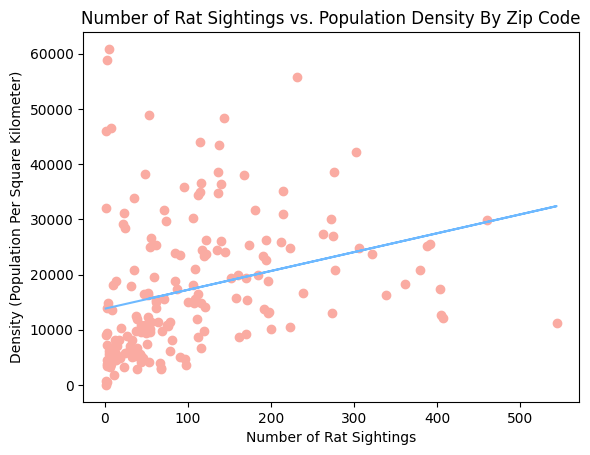

Correlation Coefficient0.2905870072765726


In [18]:
import numpy as np

# Get population density dataset
pop_density_df = pd.read_csv("uszips.csv")
pop_density_df = pop_density_df[['zip', 'density']]

# Filter on 2024 data
df['Created Date'] = pd.to_datetime(df['Created Date']) # DELETE IF MOVED?
merged_df = pd.merge(pop_density_df, df[df['Created Date'].dt.year == 2024], left_on='zip', right_on='Incident Zip', how='inner')

# Get number of sightings per zip code, keeping numerical order of zip
groups = merged_df.groupby('zip', as_index=False)
num_sightings = groups.size().sort_values('zip', ascending=True)

# Get unique list of zip codes in numerical order
merged_df.sort_values('zip', ascending=True, inplace=True)
zips = merged_df['zip'].unique()

# Get corresponding densities of the ordered zips
merged_df = merged_df.drop_duplicates(subset='zip', keep="first").sort_values('zip', ascending=True)

# Plot number of sightings vs. population density of zip
x = num_sightings['size']
y = merged_df['density']
a, b = np.polyfit(x, y, 1)

plt.scatter(x, y, color='#faaba2')
plt.plot(x, a*x+b, color='#6eb9ff') # line of best fit
plt.xlabel("Number of Rat Sightings")
plt.ylabel("Density (Population Per Square Kilometer)")
plt.title("Number of Rat Sightings vs. Population Density By Zip Code")
plt.show()

# Pearson correlation coefficient
print("Correlation Coefficient: " + str(np.corrcoef(x, y)[0, 1]))


# Part 3: Rat Sightings over Time & Seasons

Extract the month, week, and day from the dates in the dataset.

In [ ]:
# Convert 'Created Date' to datetime format
df['Created Date'] = pd.to_datetime(df['Created Date'])

# Extract month, week, and day information
df['Month'] = df['Created Date'].dt.month
df['Week'] = df['Created Date'].dt.isocalendar().week
df['Day'] = df['Created Date'].dt.day

# Check the updated dataframe
print(df[['Created Date', 'Month', 'Week', 'Day']].head())

         Created Date  Month  Week  Day
0 2024-05-31 00:10:00      5    22   31
1 2024-06-01 15:01:00      6    22    1
2 2024-06-06 10:08:00      6    23    6
3 2024-06-25 11:34:00      6    26   25
4 2024-06-27 10:48:00      6    26   27


Visualize Rat sightings across Months

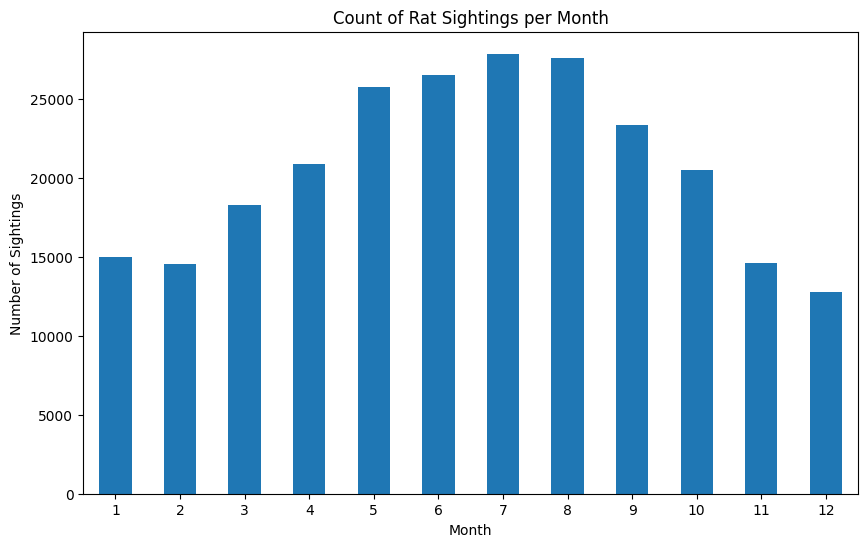

In [ ]:
# Count rat sightings per month
rat_sightings_by_month = df['Month'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(10, 6))
rat_sightings_by_month.plot(kind='bar')
plt.title('Count of Rat Sightings per Month')
plt.xlabel('Month')
plt.ylabel('Number of Sightings')
plt.xticks(rotation=0)
plt.show()

## T-test: Summer vs Winter Rat Sightings

In [ ]:
# Example: Compare rat sightings between Winter (Dec-Feb) and Summer (Jun-Aug)
winter_months = [12, 1, 2]
summer_months = [6, 7, 8]

# Get sightings for winter and summer
winter_sightings = df[df['Month'].isin(winter_months)]['Month'].count()
summer_sightings = df[df['Month'].isin(summer_months)]['Month'].count()

# Filter the data for winter and summer months
winter_data = df[df['Month'].isin([12, 1, 2])]
summer_data = df[df['Month'].isin([6, 7, 8])]


In [ ]:
# Check the length of data for both groups
print("Winter sightings count:", len(winter_data))
print("Summer sightings count:", len(summer_data))

Winter sightings count: 42325
Summer sightings count: 82017


In [ ]:
# Check for NaN values in these groups
print("NaN in winter data:", winter_data.isna().sum())
print("NaN in summer data:", summer_data.isna().sum())

# Drop rows with missing values in 'Incident Zip', 'Latitude', or 'Longitude'
winter_data_clean = winter_data.dropna(subset=['Incident Zip', 'Latitude', 'Longitude'])
summer_data_clean = summer_data.dropna(subset=['Incident Zip', 'Latitude', 'Longitude'])

# Check cleaned data
print("Cleaned winter data count:", len(winter_data_clean))
print("Cleaned summer data count:", len(summer_data_clean))

NaN in winter data: Created Date       0
Location Type      0
Incident Zip       0
Community Board    0
Borough            0
Latitude           0
Longitude          0
Month              0
Week               0
Day                0
dtype: int64
NaN in summer data: Created Date       0
Location Type      0
Incident Zip       0
Community Board    0
Borough            0
Latitude           0
Longitude          0
Month              0
Week               0
Day                0
dtype: int64
Cleaned winter data count: 42325
Cleaned summer data count: 82017


T test: T-test is only valid if the sample size is normally distributed and independent. By the Central Limit theorem, since the sizes of both datasets are over 30, a normal distribution can be assumed.

In [ ]:
# Count the number of sightings per day in both seasons
winter_sightings_per_day = winter_data_clean['Created Date'].dt.date.value_counts()
summer_sightings_per_day = summer_data_clean['Created Date'].dt.date.value_counts()

# Perform the t-test comparing the number of sightings per day in winter vs summer
t_stat, p_value = stats.ttest_ind(winter_sightings_per_day, summer_sightings_per_day, equal_var=False)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -32.34263324473203, P-value: 1.700947373903577e-191


# Part 4: Rat Sightings and Location

# ANOVA Test :  Zip Codes


H0: There are no significant differences in rat sightings across boroughs

H1: There are significant differences in rat sightings across boroughs


We Reject the null hypothesis (H0) because the p-value is less than the alpha value of 0.05.

In [ ]:
from scipy import stats

sightings_per_zip = df.groupby(['Borough', 'Incident Zip']).size().reset_index(name='Sightings')

# group by Borough to prepare for ANOVA
sightings_by_borough = sightings_per_zip.groupby('Borough')['Sightings'].apply(list).reset_index()
print(sightings_by_borough)

# Extracting sightings lists for each borough
borough_groups = sightings_by_borough['Sightings'].tolist()

# Perform ANOVA
f_statistic, p_value = stats.f_oneway(*borough_groups)

print(f'P-value: {p_value}')

         Borough                                          Sightings
0          BRONX  [1774, 2497, 2578, 1279, 1835, 3619, 3070, 318...
1       BROOKLYN  [1981, 2238, 730, 2701, 3688, 3757, 2287, 1472...
2      MANHATTAN  [24, 8, 899, 2457, 1700, 102, 106, 165, 408, 2...
3         QUEENS  [90, 66, 17, 1382, 795, 1184, 771, 1233, 866, ...
4  STATEN ISLAND  [1024, 587, 633, 821, 892, 1195, 180, 585, 413...
P-value: 1.685807160128314e-09


Next, let's visualize the results of the ANOVA Test.

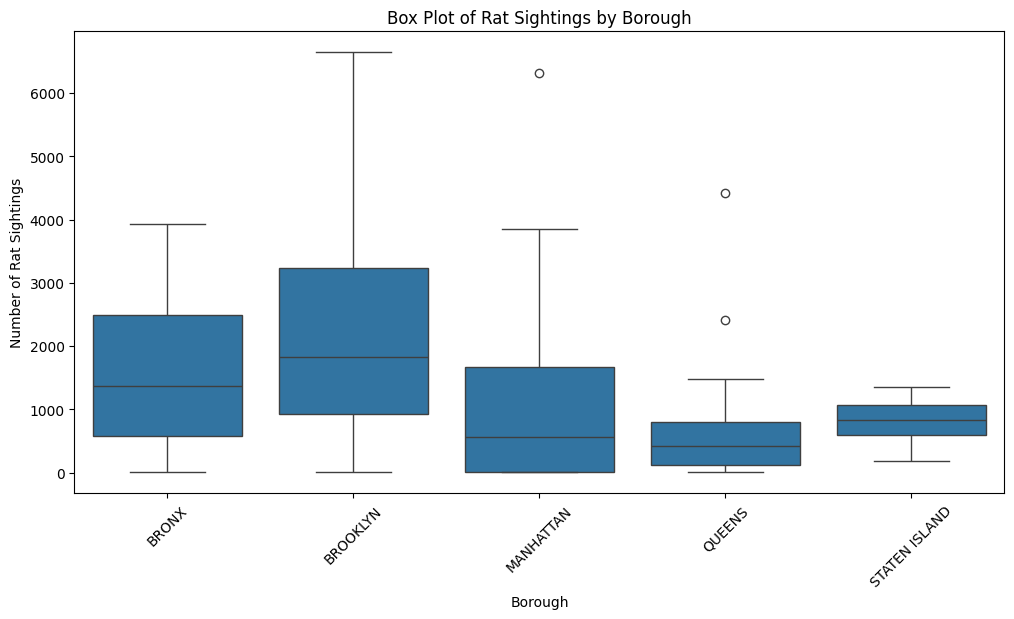

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='Borough', y='Sightings', data=sightings_per_zip)
plt.title('Box Plot of Rat Sightings by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Rat Sightings')
plt.xticks(rotation=45)
plt.show()


### Post-hoc Test: Turkey's HSD Test



In [ ]:
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd

long_df = sightings_per_zip[['Borough', 'Sightings']].copy()
long_df = long_df.explode('Sightings').reset_index(drop=True)
long_df['Sightings'] = pd.to_numeric(long_df['Sightings'], errors='coerce')

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(long_df['Sightings'], long_df['Borough'], alpha=0.05)
print(tukey_results)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
  group1      group2     meandiff  p-adj    lower      upper   reject
---------------------------------------------------------------------
    BRONX      BROOKLYN   635.8062 0.1739  -149.8804 1421.4929  False
    BRONX     MANHATTAN  -558.2111  0.216 -1283.2055  166.7833  False
    BRONX        QUEENS  -955.6202 0.0033 -1680.6146 -230.6257   True
    BRONX STATEN ISLAND  -726.2414 0.3827 -1843.2233  390.7405  False
 BROOKLYN     MANHATTAN -1194.0173    0.0 -1836.3486  -551.686   True
 BROOKLYN        QUEENS -1591.4264    0.0 -2233.7577 -949.0951   True
 BROOKLYN STATEN ISLAND -1362.0476 0.0048 -2427.2336 -296.8616   True
MANHATTAN        QUEENS  -397.4091 0.3045  -963.8921  169.0739  False
MANHATTAN STATEN ISLAND  -168.0303 0.9913  -1189.272  853.2114  False
   QUEENS STATEN ISLAND   229.3788 0.9721  -791.8629 1250.6205  False
---------------------------------------------------------------------


The results suggest that Brooklyn has significantly lower rat sightings compared to boroughs such as Manhattan, Queens, and Staten Island.

The results do not suggest significant differences in sightings between Bronx and Brooklyn, or between some other borough pairs.

# Part 5: Rat Sightings Across Income Groups and Residential/NonResidential Areas